# *Machine Learning* em Reanimação Neonatal
Projeto 1 da Disciplina de Aprendizado de Máquina - PPgEEC/UFRN

## Etapa 4 - TRAIN

Neste notebook será realizado o treinamento do algoritmo *Decision Tree* utilizando os artefatos criados na etapa de segregação.

## 1.  Configuração do Ambiente e Leitura de Artefatos

In [2]:
import logging
import wandb
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

Login no wandb

In [3]:
!wandb login HASH --relogin

wandb: Appending key for api.wandb.ai to your netrc file: /Users/ericcalasans/.netrc


Variáveis globais

In [4]:
# Tamanho do conjunto de teste(fração do dataset que é utilizada como dados de teste)
val_size = 0.3

# Coeficiente de aleatoriedade
seed = 1618

# Variável alvo(target)
stratify = 'reanimacao'

# Artefato de entrada
input_artifact = 'mlreanimacao/train.csv:latest'

# Tipo do artefato
artifact_type = 'Train'

Configurações de log

In [5]:
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# Objeto logging
logger = logging.getLogger()

Captura de artefato

In [6]:
run = wandb.init(project='mlreanimacao', job_type='train')

# Registra um log desta ação
logger.info("Baixando artefato e realizando leitura...")
artifact = run.use_artifact(input_artifact)
artifact_file = artifact.file()
df_to_split = pd.read_csv(artifact_file)

wandb: Currently logged in as: ecalasans (use `wandb login --relogin` to force relogin)


03-06-2022 14:58:17 Baixando artefato e realizando leitura...


## 3.  Treinamento

Divisão do conjunto de treinamento

In [7]:
logger.info("Divisão em train/val")

x_train, x_val, y_train, y_val = train_test_split(df_to_split.drop(labels=stratify,axis=1),
                                                  df_to_split[stratify],
                                                  test_size=val_size,
                                                  random_state=seed,
                                                  shuffle=True,
                                                  stratify=df_to_split[stratify])

03-06-2022 14:58:23 Divisão em train/val


In [8]:
x_train

,idade_materna,fumo,alcool,psicoativas,tpp,dpp,oligoamnio,sifilis,hiv,covid_mae,dheg,dm,sexo
351,32.0,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,n_dheg,n_dm,Masculino
267,26.0,n_fumo,n_alcool,n_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,s_dheg,s_dm,Feminino
189,21.0,n_fumo,n_alcool,n_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,n_dheg,n_dm,Masculino
324,36.0,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,n_dheg,n_dm,Masculino
229,21.0,n_fumo,n_alcool,n_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,n_dheg,n_dm,Feminino
...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,39.0,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,s_sifilis,n_hiv,n_covid,n_dheg,n_dm,Masculino
26,37.0,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,s_oligo,n_sifilis,n_hiv,n_covid,s_dheg,s_dm,Feminino
228,26.0,n_fumo,n_alcool,n_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,s_dheg,n_dm,Masculino
238,20.0,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,d_sifilis,d_hiv,n_covid,n_dheg,n_dm,Masculino


In [9]:
logger.info("x train: {}".format(x_train.shape))
logger.info("y train: {}".format(y_train.shape))
logger.info("x val: {}".format(x_val.shape))
logger.info("y val: {}".format(y_val.shape))

03-06-2022 14:58:26 x train: (246, 13)
03-06-2022 14:58:26 y train: (246,)
03-06-2022 14:58:26 x val: (106, 13)
03-06-2022 14:58:26 y val: (106,)


### 3.1. Preparação do *Dataset*

Remoção de *outliers* - só tem sentido com dados numéricos.

Será considerada a *feature* **idade_materna** como possível fonte de *outliers* e um *boxplot* da feature revelará se existe outliers a serem tratados.

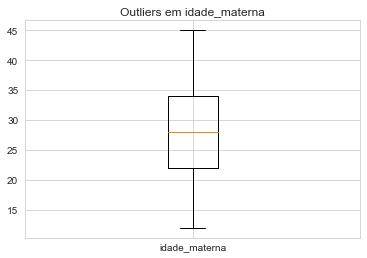

In [9]:
%matplotlib inline
plt.boxplot(df_to_split['idade_materna'])
plt.title('Outliers em idade_materna')
plt.xlabel('idade_materna')
plt.tick_params(
    axis='x',
    bottom=False,
    labelbottom=False
)
plt.show()

A princípio não parece haver *outliers* na *feature* porém será deixada a opção de tratamento para os mesmos em caso de surgirem no *dataset*.

In [10]:
logger.info("Remoção de outliers")

# Variável temporária
x = x_train['idade_materna'].copy()

# Redimensiona variável para adequar ao procedimento - técnica sugerida pela mensagem de erro
x = x.values.reshape(-1, 1)

# Identifica e prevê outliers em um único passo
lof = LocalOutlierFactor()
outlier = lof.fit_predict(x)
mask = outlier != -1

03-06-2022 14:58:33 Remoção de outliers


In [11]:
logger.info("x_train shape [original]: {}".format(x_train.shape))
logger.info("x_train shape [outlier removal]: {}".format(x_train.loc[mask,:].shape))

03-06-2022 14:58:34 x_train shape [original]: (246, 13)
03-06-2022 14:58:34 x_train shape [outlier removal]: (239, 13)


Após execução do passo anterior, percebe-se que o algoritmo considerou a existência de 7 *outliers* e os removeu, reduzindo o tamanho do *dataset*.  Desta forma o conjunto de treinamento será atualizado.

In [12]:
x_train = x_train.loc[mask,:].copy()
y_train = y_train[mask].copy()

In [13]:
x_train

,idade_materna,fumo,alcool,psicoativas,tpp,dpp,oligoamnio,sifilis,hiv,covid_mae,dheg,dm,sexo
351,32.0,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,n_dheg,n_dm,Masculino
267,26.0,n_fumo,n_alcool,n_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,s_dheg,s_dm,Feminino
189,21.0,n_fumo,n_alcool,n_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,n_dheg,n_dm,Masculino
324,36.0,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,n_dheg,n_dm,Masculino
229,21.0,n_fumo,n_alcool,n_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,n_dheg,n_dm,Feminino
...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,39.0,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,s_sifilis,n_hiv,n_covid,n_dheg,n_dm,Masculino
26,37.0,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,s_oligo,n_sifilis,n_hiv,n_covid,s_dheg,s_dm,Feminino
228,26.0,n_fumo,n_alcool,n_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,s_dheg,n_dm,Masculino
238,20.0,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,d_sifilis,d_hiv,n_covid,n_dheg,n_dm,Masculino


### 3.2.  Codificação da Variável *Target*

Neste passo a variável *target* categórica terá seus valores de texto substituídos por uma valor numérico.  Originalmente, no *dataset* recebido da API, as variáveis são já codificadas em valores numéricos pelo operador do sistema de alimentação dos dados via dicionário de dados.  No entanto, este processo foi revertido aqui na etapa de preprocessamento para fins didáticos.

In [14]:
y_train

351    nr
267    nr
189    nr
324    nr
229    sr
       ..
309    nr
26     nr
228    nr
238    nr
58     nr
Name: reanimacao, Length: 239, dtype: object

In [111]:
logger.info("Codificando variável target")
# Objeto codificador
le = LabelEncoder()

# Treinamento e transformação do conjunto de treinamento
y_train = le.fit_transform(y_train)

# Transformação do conjunto de validação - não é necessário treinamento pois já
# foi realizado
y_val = le.transform(y_val)

logger.info("Classes [0, 1]: {}".format(le.inverse_transform([0, 1])))

03-06-2022 11:17:24 Codificando variável target
03-06-2022 11:17:24 Classes [0, 1]: ['nr' 'sr']


In [112]:
y_train

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0])

In [113]:
y_val

array([1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0])

### 3.3. Codificação das *Features*

#### 3.3.1. *Features* Categóricas

In [18]:
x_train.shape

(239, 13)

Seleciona as *features* categóricas

In [19]:
colunas = x_train.select_dtypes('object').columns.to_list()
colunas

['fumo',
 'alcool',
 'psicoativas',
 'tpp',
 'dpp',
 'oligoamnio',
 'sifilis',
 'hiv',
 'covid_mae',
 'dheg',
 'dm',
 'sexo']

In [20]:
x_val.fumo.unique()

array(['n_fumo', 'd_fumo', 's_fumo'], dtype=object)

In [21]:
for col in colunas:
    # Cria o objeto OneHotEncoder
    one_hot = OneHotEncoder(sparse=False, drop='first')

    # Treinamento do codificador
    one_hot.fit(x_train[col].values.reshape(-1,1))

    # Criação de novas colunas
    x_train[one_hot.get_feature_names_out()] = one_hot.transform(x_train[col].values.reshape(-1,1))
    x_val[one_hot.get_feature_names_out()] = one_hot.transform(x_val[col].values.reshape(-1,1))

In [22]:
x_train

,idade_materna,fumo,alcool,psicoativas,tpp,dpp,oligoamnio,sifilis,hiv,covid_mae,...,x0_s_sifilis,x0_n_hiv,x0_s_hiv,x0_n_covid,x0_s_covid,x0_n_dheg,x0_s_dheg,x0_n_dm,x0_s_dm,x0_Masculino
351,32.0,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
267,26.0,n_fumo,n_alcool,n_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
189,21.0,n_fumo,n_alcool,n_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
324,36.0,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
229,21.0,n_fumo,n_alcool,n_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,39.0,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,s_sifilis,n_hiv,n_covid,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
26,37.0,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,s_oligo,n_sifilis,n_hiv,n_covid,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
228,26.0,n_fumo,n_alcool,n_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
238,20.0,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,d_sifilis,d_hiv,n_covid,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0


In [23]:
x_val

,idade_materna,fumo,alcool,psicoativas,tpp,dpp,oligoamnio,sifilis,hiv,covid_mae,...,x0_s_sifilis,x0_n_hiv,x0_s_hiv,x0_n_covid,x0_s_covid,x0_n_dheg,x0_s_dheg,x0_n_dm,x0_s_dm,x0_Masculino
161,21.0,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,d_covid,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
326,38.0,n_fumo,n_alcool,n_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
295,28.0,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
179,23.0,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
48,31.0,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,n_sifilis,d_hiv,n_covid,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,30.0,n_fumo,d_alcool,d_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
155,41.0,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,d_covid,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
230,21.0,n_fumo,n_alcool,d_psico,n_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
314,42.0,n_fumo,n_alcool,d_psico,n_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0


In [24]:
x_train.drop(columns=colunas, axis=1, inplace=True)
x_val.drop(columns=colunas, axis=1, inplace=True)

In [25]:
x_train.head()

,idade_materna,x0_n_fumo,x0_s_fumo,x0_n_alcool,x0_s_alcool,x0_n_psico,x0_s_psico,x0_n_tpp,x0_s_tpp,x0_n_dpp,...,x0_s_sifilis,x0_n_hiv,x0_s_hiv,x0_n_covid,x0_s_covid,x0_n_dheg,x0_s_dheg,x0_n_dm,x0_s_dm,x0_Masculino
351,32.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
267,26.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
189,21.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
324,36.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
229,21.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [26]:
x_val.head()

,idade_materna,x0_n_fumo,x0_s_fumo,x0_n_alcool,x0_s_alcool,x0_n_psico,x0_s_psico,x0_n_tpp,x0_s_tpp,x0_n_dpp,...,x0_s_sifilis,x0_n_hiv,x0_s_hiv,x0_n_covid,x0_s_covid,x0_n_dheg,x0_s_dheg,x0_n_dm,x0_s_dm,x0_Masculino
161,21.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
326,38.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
295,28.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
179,23.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
48,31.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [27]:
# Finaliza a execução do wandb
run.finish()

## 4. Construção do *Pipeline*

Executar parte do código acima que restaura a estrutura do artefato até antes do *OneHotEncoding*

### 4.1. Criação da Classe **FeatureSelection**

In [46]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    # Construtor
    def __init__(self, feature_names):
        self.feature_names = feature_names

    # Override de fit
    def fit(self, X, y=None):
        return self

    # Retorna as colunas passadas no construtor
    def transform(self, X, y=None):
        return X[self.feature_names]

In [47]:
# Teste da classe
fs = FeatureSelector(x_train.select_dtypes("object").columns.to_list())
df = fs.fit_transform(x_train)
df.head()

,fumo,alcool,psicoativas,tpp,dpp,oligoamnio,sifilis,hiv,covid_mae,dheg,dm,sexo
351,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,n_dheg,n_dm,Masculino
267,n_fumo,n_alcool,n_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,s_dheg,s_dm,Feminino
189,n_fumo,n_alcool,n_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,n_dheg,n_dm,Masculino
324,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,n_dheg,n_dm,Masculino
229,n_fumo,n_alcool,n_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,n_dheg,n_dm,Feminino


### 4.2. Criação da Classe **CategoricalTransformer**

In [48]:
class CategoricalTransformer(BaseEstimator, TransformerMixin):
    # Construtor
    def __init__(self, new_features=True, colnames=None):
        self.new_features = new_features
        self.colnames = colnames

    # Override de fit
    def fit(self, X, y=None):
        return self

    # Override de get_feature_names_out
    def get_feature_names_out(self):
        return self.colnames.tolist()

    # Transformer method we wrote for this transformer
    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # Remove eventuais espaços em branco dos valores - a princípio isso não existe na base de dados
        df = df.apply(lambda row: row.str.strip())
        
        # Opção de fazer preprocessamento se new_features for True(padrão da classe)
        if self.new_features:
            df['fumo'].fillna(2, inplace=True)
            df['alcool'].fillna(2, inplace=True)
            df['psicoativas'].fillna(2, inplace=True)
            df['tpp'].fillna(2, inplace=True)
            df['dheg'].fillna(2, inplace=True)
            df['dm'].fillna(2, inplace=True)
            df['sexo'].fillna(3, inplace=True)
            df['oligoamnio'].fillna(2, inplace=True)
            df['dpp'].fillna(2, inplace=True)
            df['sifilis'].fillna(2, inplace=True)
            df['hiv'].fillna(2, inplace=True)
            df['covid_mae'].fillna(2, inplace=True)

            # Elimina valores com sexo indefinido
            df.drop(df[df['sexo'] == 3].index, inplace=True)
            
            # Categoriza as features pois o artefato retorna sempre valores numéricos
            df['fumo'].replace([0, 1, 2, 3], ['n_fumo', 's_fumo', 'n_fumo', 'd_fumo'], inplace=True)
            df['alcool'].replace([0, 1, 2, 3], ['n_alcool', 's_alcool', 'n_alcool', 'd_alcool'], inplace=True)
            df['psicoativas'].replace([0, 1, 2, 3], ['n_psico', 's_psico', 'n_psico', 'd_psico'], inplace=True)
            df['tpp'].replace([0, 1, 2, 3], ['n_tpp', 's_tpp', 'n_tpp', 'd_tpp'], inplace=True)
            df['dheg'].replace([0, 1, 2, 3], ['n_dheg', 's_dheg', 'n_dheg', 'd_dheg'], inplace=True)
            
                # Melhor adequação da feature sexo
            df['sexo'].replace([1,2], ['Feminino', 'Masculino'], inplace=True)
            df['dpp'].replace([0, 1, 2, 3], ['n_dpp', 's_dpp', 'n_dpp', 'd_dpp'], inplace=True)
            df['oligoamnio'].replace([0, 1, 2, 3], ['n_oligo', 's_oligo', 'n_oligo', 'd_oligo'], inplace=True)
            df['sifilis'].replace([0, 1, 2, 3], ['n_sifilis', 's_sifilis', 'n_sifilis', 'd_sifilis'], inplace=True)
            df['hiv'].replace([0, 1, 2, 3], ['n_hiv', 's_hiv', 'n_hiv', 'd_hiv'], inplace=True)
            df['covid_mae'].replace([0, 1, 2, 3], ['n_covid', 's_covid', 'n_covid', 'd_covid'], inplace=True)
            
                # Consolidações
            df['dm'].replace([0,1,2,3,4,5,6], ['n_dm', 'n_dm','s_dm','s_dm', 's_dm','s_dm','d_dm'], inplace=True)

        self.colnames = df.columns

        return df

In [49]:
# Validação
fs = FeatureSelector(x_train.select_dtypes("object").columns.to_list())
df = fs.fit_transform(x_train)
df.head()

,fumo,alcool,psicoativas,tpp,dpp,oligoamnio,sifilis,hiv,covid_mae,dheg,dm,sexo
351,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,n_dheg,n_dm,Masculino
267,n_fumo,n_alcool,n_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,s_dheg,s_dm,Feminino
189,n_fumo,n_alcool,n_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,n_dheg,n_dm,Masculino
324,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,n_dheg,n_dm,Masculino
229,n_fumo,n_alcool,n_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,n_dheg,n_dm,Feminino


In [50]:
ct = CategoricalTransformer(new_features=True, colnames=df.columns.to_list())
df_cat = ct.fit_transform(x_train)
df_cat.head()

,fumo,alcool,psicoativas,tpp,dpp,oligoamnio,sifilis,hiv,covid_mae,dheg,dm,sexo
351,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,n_dheg,n_dm,Masculino
267,n_fumo,n_alcool,n_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,s_dheg,s_dm,Feminino
189,n_fumo,n_alcool,n_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,n_dheg,n_dm,Masculino
324,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,n_dheg,n_dm,Masculino
229,n_fumo,n_alcool,n_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,n_dheg,n_dm,Feminino


In [51]:
x_train.select_dtypes("object").apply(pd.Series.nunique)

fumo           3
alcool         3
psicoativas    3
tpp            3
dpp            3
oligoamnio     3
sifilis        3
hiv            3
covid_mae      3
dheg           3
dm             3
sexo           2
dtype: int64

In [52]:
df_cat.apply(pd.Series.nunique)

fumo           3
alcool         3
psicoativas    3
tpp            3
dpp            3
oligoamnio     3
sifilis        3
hiv            3
covid_mae      3
dheg           3
dm             3
sexo           2
dtype: int64

### 4.3. Criação da Classe **NumericalTransformer**

In [53]:
class NumericalTransformer(BaseEstimator, TransformerMixin):
    # Tipos de scalers
    # model 0: minmax
    # model 1: standard
    # model 2: without scaler
    def __init__(self, model=0, colnames=None):
        self.model = model
        self.colnames = colnames
        self.scaler = None

    def fit(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)
        # minmax
        if self.model == 0:
            self.scaler = MinMaxScaler()
            self.scaler.fit(df)
        # standard scaler
        elif self.model == 1:
            self.scaler = StandardScaler()
            self.scaler.fit(df)
        return self

    def get_feature_names_out(self):
        return self.colnames

    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # update columns name
        self.colnames = df.columns.tolist()

        # minmax
        if self.model == 0:
            # transform data
            df = self.scaler.transform(df)
        elif self.model == 1:
            # transform data
            df = self.scaler.transform(df)
        else:
            df = df.values

        return df


In [54]:
# Validação
fs = FeatureSelector(x_train.select_dtypes("float64").columns.to_list())
df = fs.fit_transform(x_train)
df.head()

,idade_materna
351,32.0
267,26.0
189,21.0
324,36.0
229,21.0


In [55]:
nt = NumericalTransformer(model=1, colnames=df.columns.to_list())
df_nt = nt.fit_transform(df)
df_nt

array([[ 0.52206813],
       [-0.37991464],
       [-1.13156695],
       [ 1.12338998],
       [-1.13156695],
       [-1.13156695],
       [-0.37991464],
       [-1.28189741],
       [ 2.02537275],
       [ 0.97305952],
       [ 0.52206813],
       [ 0.07107675],
       [-0.98123649],
       [ 0.97305952],
       [-0.5302451 ],
       [-0.83090603],
       [ 1.87504229],
       [ 0.67239859],
       [-0.22958418],
       [-1.43222787],
       [ 0.82272906],
       [-1.43222787],
       [-1.13156695],
       [ 0.07107675],
       [ 0.82272906],
       [ 0.97305952],
       [ 1.4240509 ],
       [ 0.82272906],
       [-1.88321926],
       [ 1.57438137],
       [-0.37991464],
       [ 0.07107675],
       [-0.37991464],
       [ 0.82272906],
       [-0.98123649],
       [ 0.22140721],
       [-0.22958418],
       [ 0.52206813],
       [ 0.52206813],
       [ 0.67239859],
       [ 0.37173767],
       [-1.58255834],
       [ 0.52206813],
       [-0.37991464],
       [-0.07925372],
       [ 1

In [56]:
nt.get_feature_names_out()

['idade_materna']

### 4.4.  Encadeamento

In [114]:
# Tipos de scalers = 0 (min-max), 1 (z-score), 2 (without normalization)
numerical_model = 0

# Features categóricas
categorical_features = x_train.select_dtypes("object").columns.to_list()

# Features numéricas
numerical_features = x_train.select_dtypes("float64").columns.to_list()

# A parte de preenchimento de dados faltantes já é realizada pela classe CategoricalTransformer
categorical_pipeline = Pipeline(steps=[('cat_selector', FeatureSelector(categorical_features)),
                                       ('cat_transformer', CategoricalTransformer(colnames=categorical_features)),
                                       ('cat_encoder', OneHotEncoder(sparse=False, drop="first"))
                                       ]
                                )

# A parte de preenchimento de dados faltantes já é realizada pela classe NumericalTransformer
numerical_pipeline = Pipeline(steps=[('num_selector', FeatureSelector(numerical_features)),
                                     ('num_transformer', NumericalTransformer(numerical_model,
                                                                              colnames=numerical_features))])

# Reune os Pipelines num só
full_pipeline_preprocessing = FeatureUnion(transformer_list=[('cat_pipeline', categorical_pipeline),
                                                             ('num_pipeline', numerical_pipeline)])

In [115]:
# Validação
new_data = full_pipeline_preprocessing.fit_transform(x_train)

In [116]:
new_data

array([[1.        , 0.        , 1.        , ..., 0.        , 1.        ,
        0.61538462],
       [1.        , 0.        , 1.        , ..., 1.        , 0.        ,
        0.38461538],
       [1.        , 0.        , 1.        , ..., 0.        , 1.        ,
        0.19230769],
       ...,
       [1.        , 0.        , 1.        , ..., 0.        , 1.        ,
        0.38461538],
       [1.        , 0.        , 1.        , ..., 0.        , 1.        ,
        0.15384615],
       [1.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.73076923]])

In [117]:
cat_names = list(full_pipeline_preprocessing.get_params()['cat_pipeline'][2].get_feature_names_out())
cat_names

['fumo_n_fumo',
 'fumo_s_fumo',
 'alcool_n_alcool',
 'alcool_s_alcool',
 'psicoativas_n_psico',
 'psicoativas_s_psico',
 'tpp_n_tpp',
 'tpp_s_tpp',
 'dpp_n_dpp',
 'dpp_s_dpp',
 'oligoamnio_n_oligo',
 'oligoamnio_s_oligo',
 'sifilis_n_sifilis',
 'sifilis_s_sifilis',
 'hiv_n_hiv',
 'hiv_s_hiv',
 'covid_mae_n_covid',
 'covid_mae_s_covid',
 'dheg_n_dheg',
 'dheg_s_dheg',
 'dm_n_dm',
 'dm_s_dm',
 'sexo_Masculino']

In [118]:
num_names = full_pipeline_preprocessing.get_params()['num_pipeline'][1].get_feature_names_out()
type(num_names)

list

In [119]:
df = pd.DataFrame(new_data, columns=cat_names+num_names)
df.head()

,fumo_n_fumo,fumo_s_fumo,alcool_n_alcool,alcool_s_alcool,psicoativas_n_psico,psicoativas_s_psico,tpp_n_tpp,tpp_s_tpp,dpp_n_dpp,dpp_s_dpp,...,hiv_n_hiv,hiv_s_hiv,covid_mae_n_covid,covid_mae_s_covid,dheg_n_dheg,dheg_s_dheg,dm_n_dm,dm_s_dm,sexo_Masculino,idade_materna
0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.615385
1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.384615
2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.192308
3,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.769231
4,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.192308


## 5. *Holdout Training*

Pipeline completo e treinamento

In [120]:
pipe = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                         ("classifier",DecisionTreeClassifier())
                         ]
                )

# training
logger.info("Treinando...")
pipe.fit(x_train, y_train)

# predict
logger.info("Inferindo valores...")
predict = pipe.predict(x_val)

# Evaluation Metrics
logger.info("Métricas de avaliação")
fbeta = fbeta_score(y_val, predict, beta=1, zero_division=1)
precision = precision_score(y_val, predict, zero_division=1)
recall = recall_score(y_val, predict, zero_division=1)
acc = accuracy_score(y_val, predict)

logger.info("Accuracy: {}".format(acc))
logger.info("Precision: {}".format(precision))
logger.info("Recall: {}".format(recall))
logger.info("F1: {}".format(fbeta))

03-06-2022 11:18:04 Treinando...
03-06-2022 11:18:04 Inferindo valores...
03-06-2022 11:18:04 Métricas de avaliação
03-06-2022 11:18:04 Accuracy: 0.46226415094339623
03-06-2022 11:18:04 Precision: 0.3333333333333333
03-06-2022 11:18:04 Recall: 0.29545454545454547
03-06-2022 11:18:04 F1: 0.3132530120481928


In [1]:
x_train

NameError: name 'x_train' is not defined

Upload de informações para o *wandb*

In [121]:
run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

Avalia possíveis vieses no modelo

In [ ]:
# predict bias
logger.info("Inferindo viés...")
predict_bias = pipe.predict(x_train)

# Evaluation Metrics
logger.info("Métricas de avaliação de viés")
fbeta = fbeta_score(y_train, predict_bias, beta=1, zero_division=1)
precision = precision_score(y_train, predict_bias, zero_division=1)
recall = recall_score(y_train, predict_bias, zero_division=1)
acc = accuracy_score(y_train, predict_bias)

logger.info("Bias Accuracy: {}".format(acc))
logger.info("Bias Precision: {}".format(precision))
logger.info("Bias Recall: {}".format(recall))
logger.info("Bias F1: {}".format(fbeta))

Observa-se que, mesmo para os dados de treinamento, ainda há um certo grau de erro em reconhecer quem precisa de reanimação ou não porém, considerando um IC de 95%, pode-se dizer que o modelo é aceitável.

Comparação de métricas

In [78]:
print(classification_report(y_val,predict))

              precision    recall  f1-score   support

           0       0.54      0.56      0.55        62
           1       0.34      0.32      0.33        44

    accuracy                           0.46       106
   macro avg       0.44      0.44      0.44       106
weighted avg       0.46      0.46      0.46       106



Matriz de confusão

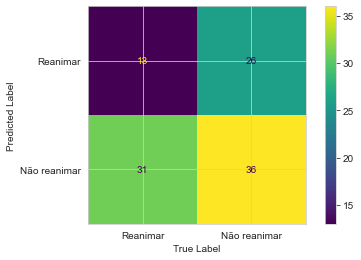

In [122]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(predict,y_val,labels=[1,0]),
                       display_labels=["Reanimar","Não reanimar"]).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

In [80]:
df = pd.DataFrame(y_val, columns=['TrueValue'])

In [81]:
df[df['TrueValue'] == 1].count()

TrueValue    44
dtype: int64

Gráficos do treinamento

In [82]:
cat_names = pipe.named_steps['full_pipeline'].get_params()["cat_pipeline"][2].get_feature_names_out().tolist()
num_names = pipe.named_steps['full_pipeline'].get_params()["num_pipeline"][1].get_feature_names_out()
all_names = cat_names + num_names
all_names

['fumo_n_fumo',
 'fumo_s_fumo',
 'alcool_n_alcool',
 'alcool_s_alcool',
 'psicoativas_n_psico',
 'psicoativas_s_psico',
 'tpp_n_tpp',
 'tpp_s_tpp',
 'dpp_n_dpp',
 'dpp_s_dpp',
 'oligoamnio_n_oligo',
 'oligoamnio_s_oligo',
 'sifilis_n_sifilis',
 'sifilis_s_sifilis',
 'hiv_n_hiv',
 'hiv_s_hiv',
 'covid_mae_n_covid',
 'covid_mae_s_covid',
 'dheg_n_dheg',
 'dheg_s_dheg',
 'dm_n_dm',
 'dm_s_dm',
 'sexo_Masculino',
 'idade_materna']

In [83]:
# Visualize all classifier plots
# For a complete documentation please see: https://docs.wandb.ai/guides/integrations/scikit
wandb.sklearn.plot_classifier(pipe.get_params()["classifier"],
                              full_pipeline_preprocessing.transform(x_train),
                              full_pipeline_preprocessing.transform(x_val),
                              y_train,
                              y_val,
                              predict,
                              pipe.predict_proba(x_val),
                              [0,1],
                              model_name='DT', feature_names=all_names)

wandb: 
wandb: Plotting DT.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: WARNING wandb.plots.* functions are deprecated and will be removed in a future release. Please use wandb.plot.* instead.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


In [84]:
run.finish()

## 6.  Ajuste de Hiperparâmetros

Aqui será explorada a seção **Sweep** do wandb, que disponibiliza vários métodos para o ajuste de hiperparâmetros do modelo.

In [123]:
seed = 1618

Configurações do *Sweep*

In [124]:
sweep_config = {
    # try grid or random
    "method": "random",
    "metric": {
        "name": "Accuracy",
        "goal": "maximize"
    },
    "parameters": {
        "criterion": {
            "values": ["gini","entropy"]
        },
        "splitter": {
            "values": ["random","best"]
        },
        "model": {
            "values": [0,1,2]
        },
        "random_state": {
            "values": [seed]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="mlreanimacao")

Create sweep with ID: za4s0nfc
Sweep URL: https://wandb.ai/ecalasans/mlreanimacao/sweeps/za4s0nfc


Define uma função para ser passada para o **Sweep**

In [ ]:
#pipe.named_steps['full_pipeline'].get_params()

In [125]:
def train():
    with wandb.init() as run:

        # The full pipeline
        pipe = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                                 ("classifier",DecisionTreeClassifier())
                                 ]
                        )

        # update the parameters of the pipeline that we would like to tuning
        pipe.set_params(**{"full_pipeline__num_pipeline__num_transformer__model": run.config.model})
        pipe.set_params(**{"classifier__criterion": run.config.criterion})
        pipe.set_params(**{"classifier__splitter": run.config.splitter})
        pipe.set_params(**{"classifier__random_state": run.config.random_state})

        # training
        logger.info("Training")
        pipe.fit(x_train, y_train)

        # predict
        logger.info("Infering")
        predict = pipe.predict(x_val)

        # Evaluation Metrics
        logger.info("Evaluation metrics")
        fbeta = fbeta_score(y_val, predict, beta=1, zero_division=1)
        precision = precision_score(y_val, predict, zero_division=1)
        recall = recall_score(y_val, predict, zero_division=1)
        acc = accuracy_score(y_val, predict)

        logger.info("Accuracy: {}".format(acc))
        logger.info("Precision: {}".format(precision))
        logger.info("Recall: {}".format(recall))
        logger.info("F1: {}".format(fbeta))

        run.summary["Accuracy"] = acc
        run.summary["Precision"] = precision
        run.summary["Recall"] = recall
        run.summary["F1"] = fbeta

In [126]:
wandb.agent(sweep_id=sweep_id, function=train, count=6)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: xo7apfnp with config:
wandb: 	criterion: entropy
wandb: 	model: 2
wandb: 	random_state: 1618
wandb: 	splitter: best
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/ecalasans/mlreanimacao/bmm4rm0m/file_stream
NoneType: None


03-06-2022 11:19:46 Training
03-06-2022 11:19:46 Infering
03-06-2022 11:19:46 Evaluation metrics
03-06-2022 11:19:46 Accuracy: 0.4716981132075472
03-06-2022 11:19:46 Precision: 0.34210526315789475
03-06-2022 11:19:46 Recall: 0.29545454545454547
03-06-2022 11:19:46 F1: 0.3170731707317074


wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/ecalasans/mlreanimacao/bmm4rm0m/file_stream
NoneType: None


Accuracy,0.4717
F1,0.31707
Precision,0.34211
Recall,0.29545


wandb: Agent Starting Run: 85ckxnee with config:
wandb: 	criterion: gini
wandb: 	model: 1
wandb: 	random_state: 1618
wandb: 	splitter: random
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/ecalasans/mlreanimacao/bmm4rm0m/file_stream
NoneType: None


03-06-2022 11:20:06 Training
03-06-2022 11:20:06 Infering
03-06-2022 11:20:07 Evaluation metrics
03-06-2022 11:20:07 Accuracy: 0.5660377358490566
03-06-2022 11:20:07 Precision: 0.475
03-06-2022 11:20:07 Recall: 0.4318181818181818
03-06-2022 11:20:07 F1: 0.4523809523809524


Accuracy,0.56604
F1,0.45238
Precision,0.475
Recall,0.43182


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q4ozrrk4 with config:
wandb: 	criterion: gini
wandb: 	model: 2
wandb: 	random_state: 1618
wandb: 	splitter: random
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/ecalasans/mlreanimacao/bmm4rm0m/file_stream
NoneType: None


03-06-2022 11:20:33 Training
03-06-2022 11:20:33 Infering
03-06-2022 11:20:33 Evaluation metrics
03-06-2022 11:20:33 Accuracy: 0.5660377358490566
03-06-2022 11:20:33 Precision: 0.475
03-06-2022 11:20:33 Recall: 0.4318181818181818
03-06-2022 11:20:33 F1: 0.4523809523809524


Accuracy,0.56604
F1,0.45238
Precision,0.475
Recall,0.43182


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z7axzan5 with config:
wandb: 	criterion: entropy
wandb: 	model: 0
wandb: 	random_state: 1618
wandb: 	splitter: random


03-06-2022 11:20:59 Training
03-06-2022 11:20:59 Infering
03-06-2022 11:20:59 Evaluation metrics
03-06-2022 11:20:59 Accuracy: 0.5849056603773585
03-06-2022 11:20:59 Precision: 0.5
03-06-2022 11:20:59 Recall: 0.4090909090909091
03-06-2022 11:20:59 F1: 0.45


wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/ecalasans/mlreanimacao/bmm4rm0m/file_stream
NoneType: None


Accuracy,0.58491
F1,0.45
Precision,0.5
Recall,0.40909


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zzthg1cn with config:
wandb: 	criterion: gini
wandb: 	model: 2
wandb: 	random_state: 1618
wandb: 	splitter: random


03-06-2022 11:21:26 Training
03-06-2022 11:21:26 Infering
03-06-2022 11:21:26 Evaluation metrics
03-06-2022 11:21:26 Accuracy: 0.5660377358490566
03-06-2022 11:21:26 Precision: 0.475
03-06-2022 11:21:26 Recall: 0.4318181818181818
03-06-2022 11:21:26 F1: 0.4523809523809524


wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/ecalasans/mlreanimacao/bmm4rm0m/file_stream
NoneType: None


Accuracy,0.56604
F1,0.45238
Precision,0.475
Recall,0.43182


wandb: Agent Starting Run: riohspcv with config:
wandb: 	criterion: gini
wandb: 	model: 1
wandb: 	random_state: 1618
wandb: 	splitter: best


03-06-2022 11:21:43 Training
03-06-2022 11:21:43 Infering
03-06-2022 11:21:43 Evaluation metrics
03-06-2022 11:21:43 Accuracy: 0.4811320754716981
03-06-2022 11:21:43 Precision: 0.36585365853658536
03-06-2022 11:21:43 Recall: 0.3409090909090909
03-06-2022 11:21:43 F1: 0.3529411764705882


Accuracy,0.48113
F1,0.35294
Precision,0.36585
Recall,0.34091


## 7.  Configuração, Treinamento e Exportação do Melhor Modelo

### 7.1. Configuração

Realizado a avaliação do treinamento, nesta etapa será realizado um novo treinamento do modelo, desta vez com os resultados de configuração obtidos na etapa anterior.  Revisando os dados obtidos tem-se:

In [89]:
logger.info("Accuracy: {}".format(acc))
logger.info("Precision: {}".format(precision))
logger.info("Recall: {}".format(recall))
logger.info("F1: {}".format(fbeta))

03-06-2022 10:54:50 Accuracy: 0.46226415094339623
03-06-2022 10:54:50 Precision: 0.34146341463414637
03-06-2022 10:54:50 Recall: 0.3181818181818182
03-06-2022 10:54:50 F1: 0.32941176470588235


Em consulta ao **Sweep** do wandb, duas execuções demonstraram-se mais eficientes em melhorar os índices de acurácia, F1 e *precision*, mantendo o *recall* praticamente inalterado.  Selecionou-se a **heart-sweep-5** por apresentar tempo de execução ligeiramente menor(1s menor que sua concorrente que apresenta os mesmos resultados e as mesmas configurações).

Devido a uma característica da interação entre o wandb e o jupyter se faz necessário o reinício do ambiente para que se desvincule a última execução do wandb realizada na fase de ajuste de hiperparâmetros.  Dessa forma, também se faz necessária a execução de todos os itens deste notebook exceto o **5** e **6**.  Após realizado isto, executa-se o wandb novamente selecionando o projeto e o tipo de trabalho(*job type*).

In [127]:
run = wandb.init(project='mlreanimacao', job_type='train')

wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/ecalasans/mlreanimacao/bmm4rm0m/file_stream
NoneType: None


### 7.2. Treinamento

Executa-se agora o *pipeline* com os ajustes apontados pela melhor execução no wandb.

In [129]:
# The full pipeline
pipe = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                         ("classifier",DecisionTreeClassifier())
                         ]
                )

# update the parameters of the pipeline that we would like to tuning
pipe.set_params(**{"full_pipeline__num_pipeline__num_transformer__model": 2})
pipe.set_params(**{"classifier__criterion": 'entropy'})
pipe.set_params(**{"classifier__splitter": 'random'})
pipe.set_params(**{"classifier__random_state": 1618})

# training
logger.info("Training")
pipe.fit(x_train, y_train)

# predict
logger.info("Infering")
predict = pipe.predict(x_val)

# Evaluation Metrics
logger.info("Evaluation metrics")
fbeta = fbeta_score(y_val, predict, beta=1, zero_division=1)
precision = precision_score(y_val, predict, zero_division=1)
recall = recall_score(y_val, predict, zero_division=1)
acc = accuracy_score(y_val, predict)

logger.info("Accuracy: {}".format(acc))
logger.info("Precision: {}".format(precision))
logger.info("Recall: {}".format(recall))
logger.info("F1: {}".format(fbeta))

run.summary["Accuracy"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

03-06-2022 11:22:45 Training
03-06-2022 11:22:45 Infering
03-06-2022 11:22:45 Evaluation metrics
03-06-2022 11:22:45 Accuracy: 0.5849056603773585
03-06-2022 11:22:45 Precision: 0.5
03-06-2022 11:22:45 Recall: 0.4090909090909091
03-06-2022 11:22:45 F1: 0.45


Geração de gráficos com o modelo otimizado para o wandb

In [97]:
cat_names = pipe.named_steps['full_pipeline'].get_params()["cat_pipeline"][2].get_feature_names_out().tolist()
num_names = pipe.named_steps['full_pipeline'].get_params()["num_pipeline"][1].get_feature_names_out()
all_names = cat_names + num_names
all_names

['fumo_n_fumo',
 'fumo_s_fumo',
 'alcool_n_alcool',
 'alcool_s_alcool',
 'psicoativas_n_psico',
 'psicoativas_s_psico',
 'tpp_n_tpp',
 'tpp_s_tpp',
 'dpp_n_dpp',
 'dpp_s_dpp',
 'oligoamnio_n_oligo',
 'oligoamnio_s_oligo',
 'sifilis_n_sifilis',
 'sifilis_s_sifilis',
 'hiv_n_hiv',
 'hiv_s_hiv',
 'covid_mae_n_covid',
 'covid_mae_s_covid',
 'dheg_n_dheg',
 'dheg_s_dheg',
 'dm_n_dm',
 'dm_s_dm',
 'sexo_Masculino',
 'idade_materna']

In [98]:
wandb.sklearn.plot_classifier(pipe.get_params()["classifier"],
                              full_pipeline_preprocessing.transform(x_train),
                              full_pipeline_preprocessing.transform(x_val),
                              y_train,
                              y_val,
                              predict,
                              pipe.predict_proba(x_val),
                              [0,1],
                              model_name='DT', feature_names=all_names)

wandb: 
wandb: Plotting DT.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


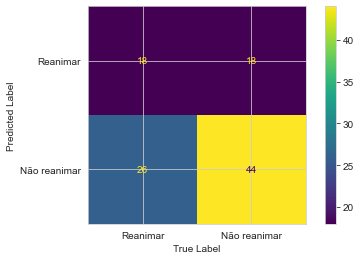

In [130]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(predict,y_val,labels=[1,0]),
                       display_labels=["Reanimar","Não reanimar"]).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

### 7.3. Exportação do Modelo

Variáveis auxiliares

In [131]:
artifact_type = "inference_artifact"
artifact_encoder = "target_encoder"
artifact_model = "model_export"

Uso do módulo **joblib** para auxiliar na tarefa de exportação realizando a serialização dos objetos **pipe** e **le**.

In [132]:
logger.info("Salvando artefatos na máquina...")
# Save the model using joblib
joblib.dump(pipe, artifact_model)

# Save the target encoder using joblib
joblib.dump(le, artifact_encoder)

03-06-2022 11:23:15 Salvando artefatos na máquina...


['target_encoder']

Geração do artefato do modelo

In [133]:
artifact = wandb.Artifact(artifact_model,
                          type=artifact_type,
                          description="Pipeline completo de Preprocessamento e Treinamento do Modelo"
                          )

logger.info("Gerando artefato do modelo...")
artifact.add_file(artifact_model)
run.log_artifact(artifact)

03-06-2022 11:23:20 Gerando artefato do modelo...


Geração do artefato do codificador da *target*

In [134]:
artifact = wandb.Artifact(artifact_encoder,
                          type=artifact_type,
                          description="Codificador da target"
                          )

logger.info("Gerando artefato do codificador...")
artifact.add_file(artifact_encoder)
run.log_artifact(artifact)

03-06-2022 11:23:27 Gerando artefato do codificador...


In [135]:
# Finaliza execução no wandb
run.finish()

Accuracy,0.58491
F1,0.45
Precision,0.5
Recall,0.40909
